# Hands-On Validation and Evaluation Metrics Solutions
***

In this notebook we'll investigate Scikit-Learn's functionality for performing cross-validation, plotting ROC curves, and plotting learning curves. 

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Helper Functions
***

In [2]:
mycolors = dict({"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373", "orange": "orange"})

def feature_hist(df: pd.DataFrame, feat: str, feat_max: int):
    """
    Function to plot SPAM vs HAM histograms for a given feature 
    
    :param df: the DataFrame 
    :param feat: the feature name 
    :param feat_max: the largest values of feature to plot 
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
    df.loc[df[feat] < feat_max].hist(column=feat, by="isSPAM", ax=axes, bins=20, edgecolor="white")
    axes[0].set_title("HAM", fontsize=16); axes[1].set_title("SPAM", fontsize=16)
    for ax in axes:
        ax.grid(alpha=0.25)
        ax.set_axisbelow("True")
        ax.set_xlabel(feat, fontsize=16)
        ax.set_ylabel("Occurrence", fontsize=16)

### Part 1: Data Examination and Visualization
***

The data we will explore in this notebook is the so-called Spambase data, which contains features extracted from SPAM and HAM emails.  The following cell will load the data. 

In [3]:
data = pd.read_csv("data/spamdata.csv", sep=" ")
X, y = data.values[:,:-1], data.values[:,-1]
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,isSPAM
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


**Part A**: The features in in this dataset are a combination of frequency counts for select words as well as other numerical features derived from the original email text.  Some of the word-count features included are things like 

- `word_freq_order`: percentage of words in the email that are the word `order` 
- `word_freq_free`: percentage of words in the email that are the word `free` 

A few other relevant features are things like 

- `capital_run_length_average`: the average length of a run of capital letters 
- `capital_run_length_longest`: the longest length of a run of capital letters 
- `char_freq_!`: the number of exclamation points that appear in the email 

Descriptions of the rest of the features can be found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names). 

e.g., The captial run length of the word "SPAM" is 4

**Part B**: 

Let's visualize some of the features by plotting histograms of the features colored by whether the email is SPAM or HAM. It seems like the number of contiguous capital letters should be a good indicator of SPAM... 

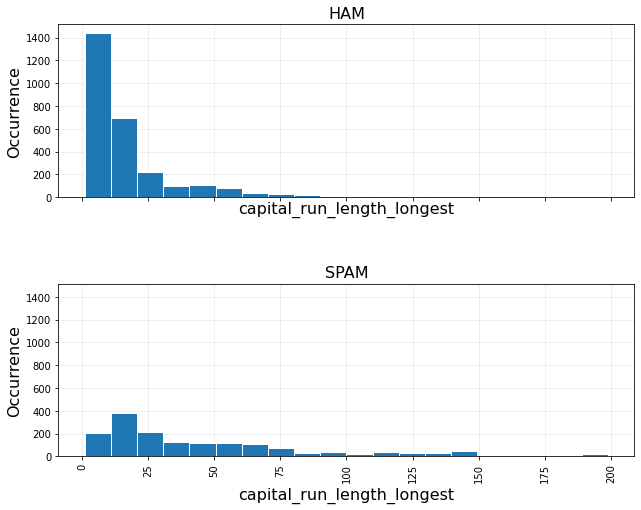

In [4]:
feature_hist(data, "capital_run_length_longest", 200)

And probably also the number of exclamation points ... 

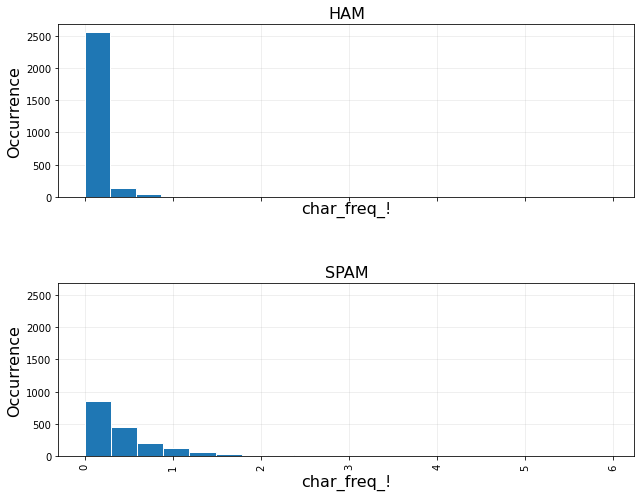

In [5]:
feature_hist(data, "char_freq_!", 6)

### Part 2: Estimating Model Performance with Cross-Validation 
***

In this section we'll use sklearn's built in cross-validation routine to estimate the accuracy of logistic regression for our data set.  

**Part A**: First, let's set a baseline by performing a train-validation split on the data and then fitting a logistic regression model. 

In [6]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1001)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.001)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001)

In [8]:
y_test

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [7]:
logreg.predict(X_test)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

Next we'll evaluate the error on the validation set and see how well we did. 

In [10]:
mean_val_score = sum([1 if yhat == y else 0 for yhat, y in zip(logreg.predict(X_test), y_test)]) / len(y_test)
print("val accuracy: {:.3f}".format(mean_val_score))

val accuracy: 0.852


In [ ]:
test_acc = logreg.score(X_test, y_test)
print("test accuracy: {:.3f}".format(test_acc))

**Part B**: Now we will use cross validation to choose the best parameter. Try it now with $k=5$ folds. 

Now let us first run cross validation with default parameter.

NOTE: Refer to the documenation of the [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function in Scikit-learn.

In [13]:
from sklearn.model_selection import cross_validate 

scores =  cross_validate(LogisticRegression(C=0.001), X_test, y_test, cv=5, return_train_score=True)
mean_train_score = np.mean(scores['train_score'])
mean_val_score =  np.mean(scores['test_score'])
print("mean train score: {:.3f} val score: {:.3f}".format(mean_train_score, mean_val_score))

mean train score: 0.761 val score: 0.760


**Part C**: Now let us try different parameters and see which parameter gives the best cross validation score.

0.03125


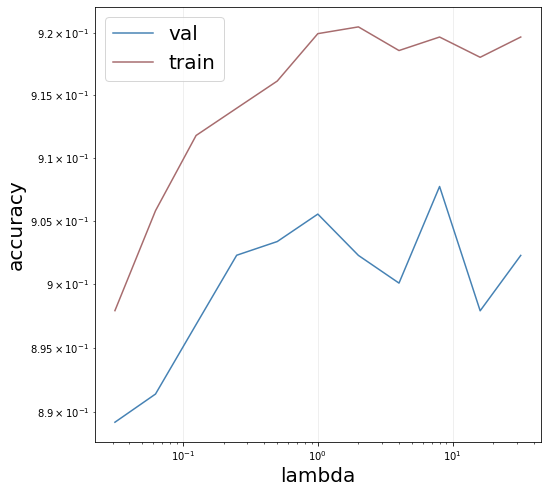

In [16]:
lambdas = np.logspace(5, -5, 11, base=2)
best_score, best_lambda = None, None
mean_train_scores, mean_val_scores = [], []

for lambda_val in lambdas:
    logreg = LogisticRegression(C=lambda_val)
    scores =  cross_validate(logreg, X_test, y_test, cv=5, return_train_score=True)
    mean_train_score = np.mean(scores['train_score'])
    mean_val_score = np.mean(scores['test_score'])
    mean_train_scores.append(mean_train_score)
    mean_val_scores.append(mean_val_score)
    
    if best_score == None or mean_val_score < best_score:
        best_score = mean_val_score
        best_lambda = lambda_val
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.loglog(lambdas, mean_val_scores, color=mycolors["blue"])
ax.loglog(lambdas, mean_train_scores, color=mycolors["red"])
ax.grid(alpha=0.25)
ax.set_xlabel("lambda", fontsize=20)
ax.set_ylabel("accuracy", fontsize=20)
ax.legend(["val", "train"], fontsize=20)
print(best_lambda)

**Part D**: Use best lambda to train a classifier and run on the test set.

In [17]:
logreg = LogisticRegression(C=best_lambda)
logreg.fit(X_train, y_train)
print("test accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

test accuracy: 0.917


### Part 3: Evaluating Model Performance with the ROC curve 
***

Note that SPAM classification is an application in which we might want to finely tune the true positive rate and false positive rate of our classifier. 

**Part A**: Think about SPAM classification.  What kinds of classification errors would be the most detrimental? 


Classifying a HAM as a SPAM. That would suck because important emails could be missed.best_score == None

**Part B**: Let's plot a ROC curve for our Logistic Regression classifier. Scikit-Learn's [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) routine computes the FPR and TPR for a range of possible thresholds in the data which you can then use to plot. Check out the documentation, and then fill in the code below to plot the curve for our Logistic Regression SPAM classifier. 

Closest fpr to 0.01 is 0.0106951871657754 with tpr of 0.44722222222222224


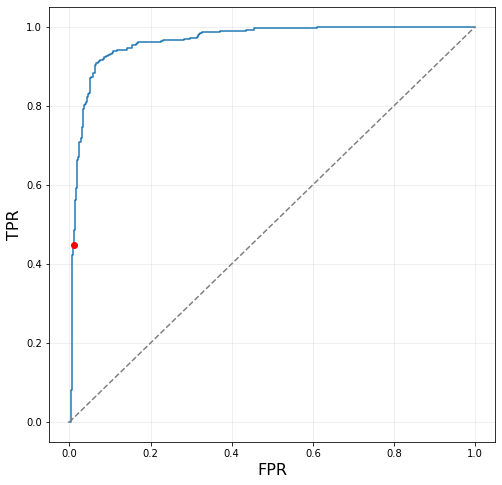

In [28]:
from sklearn.metrics import roc_curve

logreg = LogisticRegression(C=best_lambda) 
logreg.fit(X_train, y_train)
y_test_scores = logreg.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_test_scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

ax.plot(fpr, tpr)

ax.plot([0,1],[0,1], ls="--", color="gray")
ax.grid(alpha=0.25)
ax.set_xlabel("FPR", fontsize=16)
ax.set_ylabel("TPR", fontsize=16);

# TODO for Part C: find the TPR for FPR at 0.01
loc = np.where((fpr < 0.011) & (fpr > 0.009))[0][0]
ax.plot(fpr[loc], tpr[loc], "ro")
print(f"Closest fpr to 0.01 is {fpr[loc]} with tpr of {tpr[loc]}")

**Part C**: Let's suppose you want to use your ROC curve to decide how your model would perform if you fixed highest the false positive rate that you're willing to accept for your classifier.  Modify your code above to overlay a red dot on the ROC curve at your desired FPR level.  What threshold does this correspond to? At this specific FPR, do you think our model is good enough to real-life SPAM classification?  